# HW02 - Mourning Tweets

## Import Data

In [1]:
# Import Libraries
import nltk
import csv
import string
import numpy as np
import pandas as pd

from IPython.display import clear_output

In [2]:
# Download nltk corpus
#nltk.download()

# Import fnmourning dataset
raw_df = pd.read_csv('./data/fnmourning.csv', sep = ',')

# Glimpse to raw dataset
raw_df.head()

,text,tag,lang,emoticon
0,"Hoy uno de mis tíos falleció por COVID-19, no ...",mourning,es,0
1,"Hoy falleció mi abuela. Y eso, sin velorio, si...",mourning,es,0
2,Muere el primer médico en activo por Covid-19 ...,mourning,es,0
3,Historia de una victoria. Historia de los últi...,mourning,es,1
4,He visto dos personas a las que les tomé cariñ...,mourning,es,0


In [3]:
# Replace string tags with binary tags
raw_df.tag = raw_df.tag.replace('mourning',1)
raw_df.tag = raw_df.tag.replace('no mourning',0)

# Split dataset by language
es_df = raw_df[(raw_df.lang == "es")]
en_df = raw_df[(raw_df.lang == "en")]

## Mourning Lexicons

### Process Tweets

In [4]:
# Tweet tokenizer 
from gensim.parsing.preprocessing import remove_stopwords
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

def process_tweet(tokenizer, tweet, stop_words):
    """ Applies standard pre-processing to given tweet.
    
    Args:
        text (str): tweet to preprocess.
        language (str): languague of the tweet.
        stop_words (str): list of words to be removed.
    
    Returns:
        list: preprocessed text.
    
    """
    
    # Remove punctuations and convert characters to lower case
    tweet_nopunct = "".join([char.lower() for char in tweet if char not in string.punctuation]) 
    
    # Tokenize words
    tk_tweet = tokenizer.tokenize(tweet_nopunct)
    
    # Remove stop words
    relevant_words=[]
    for word in tk_tweet:
        if word not in stop_words:
            relevant_words.append(word)
    
    #print(relevant_words)
    
    # Returns processed text
    return relevant_words
    
# Creates tweet tokenizer
tt = TweetTokenizer(preserve_case=False, reduce_len=True, strip_handles=True)

# Tokenize tweets in ES dataset
es_stop_words = stopwords.words('spanish')
es_tweets = []
for tweet in es_df.text:
    # Tokenize tweets
    es_tweets.append(process_tweet(tt, tweet, es_stop_words))

# Tokenize tweets in EN dataset
en_stop_words = stopwords.words('english')
en_tweets = []
for tweet in en_df.text:
    # Tokenize tweets
    en_tweets.append(process_tweet(tt, tweet, en_stop_words))

In [5]:
# Build dictionaries
from gensim import corpora

# Convert tweets to ES dictionary
es_dict = corpora.Dictionary(es_tweets)
# Filter extremes
es_dict.filter_extremes(no_below=3, no_above=0.9)

# Convert tweets to ES dictionary
en_dict = corpora.Dictionary(en_tweets)
# Filter extremes
en_dict.filter_extremes(no_below=3, no_above=0.9)

# Glimpse to dictionaries
print('ES Dictionary:')
print(es_dict)
print('')
print('EN Dictionary:')
print(en_dict)

ES Dictionary:
Dictionary(7885 unique tokens: ['19', 'conciencia', 'condolencias', 'covid', 'cuenta']...)

EN Dictionary:
Dictionary(6584 unique tokens: ['19', 'away', 'burton', 'continue', 'covid']...)


In [6]:
# Create BOW Representation of each tweet
es_corpus = []
en_corpus = []

# ES tweets
for tweet in es_tweets:
    es_corpus.append(es_dict.doc2bow(tweet))
    
# EN tweets
for tweet in en_tweets:
    en_corpus.append(en_dict.doc2bow(tweet))

### Build Lexicons

In [7]:
def create_lexicons(dictionary, tweet_corpus, tags):
    """ Create lexicons for mourning tweets.
    
    Args:
        dictionary (gensim.corpora.dictionary.Dictionary): Dictionary for the es_.
        tweet_corpus (gensim.corpora.mmcorpus.MmCorpus): Tweet corpus with tweets in BOW Model.
        tags (numpy.array): Array with mourning tags (1=Mourning, 0=No mourning).
    
    Returns:
        pos (numpy.array): Negative score of each term.
        neg (numpy.array): Positive score of each term.
    
    """
    
    # Create pos/neg arrays
    pos_count = np.zeros(len(dictionary))
    neg_count = np.zeros(len(dictionary)) 
    
    # Tweet corpus loop
    for i, tweet in enumerate(tweet_corpus):
        
        # Term loop
        for term in tweet:
            
            # Add to pos/neg array by tag
            if tags[i]:
                pos_count[term[0]] += term[1]
            else:
                neg_count[term[0]] += term[1]

    # Convert counts to score (scaled likelihood)
    p_w = (pos_count+neg_count)/sum(pos_count+neg_count)
    
    #pos_score = (pos_count/(pos_count+neg_count))#/p_w
    #neg_score = (neg_count/(pos_count+neg_count))#/p_w
    pos_score = pos_count/sum(pos_count)
    neg_score = neg_count/sum(neg_count)

    # Return pos/neg score of terms
    return pos_score, neg_score

In [8]:
# Retrieve scores for each language
es_pos, es_neg = create_lexicons(es_dict, es_corpus, es_df.tag.values)
en_pos, en_neg = create_lexicons(en_dict, en_corpus, en_df.tag.values)

In [9]:
# Initial dataframe with terms
es_lexicons = pd.DataFrame(list(es_dict.token2id.items()), columns = ['Term','Id'])
en_lexicons = pd.DataFrame(list(en_dict.token2id.items()), columns = ['Term','Id'])

# Add pos/neg Scores
es_lexicons['PosScore'] = es_pos
es_lexicons['NegScore'] = es_neg
#es_lexicons['S. O.'] = es_so

en_lexicons['PosScore'] = en_pos
en_lexicons['NegScore'] = en_neg
#en_lexicons['S. O.'] = en_so

In [10]:
# Print top 30 ES Lexicons for mourning
pd.set_option("max_rows", 30)
es_lexicons.sort_values(by='PosScore', ascending=False).head(30)

,Term,Id,PosScore,NegScore
2,condolencias,2,0.017055,0.000322
72,qepd,72,0.016946,0.000766
276,pesar,276,0.014115,0.000077
3,covid,3,0.012612,0.024446
0,19,0,0.012449,0.022532
413,pena,413,0.011555,0.000429
18,cuarentena,18,0.011311,0.016834
30,familia,30,0.011284,0.001486
60,coronavirus,60,0.009171,0.020740
481,dolor,481,0.008412,0.000398


In [11]:
# Print top 30 EN Lexicons for mourning
en_lexicons.sort_values(by='PosScore', ascending=False).head(30)

,Term,Id,PosScore,NegScore
4,covid,4,0.028448,0.039414
11,rip,11,0.025075,0.003522
0,19,0,0.024475,0.036824
58,’,58,0.015499,0.017110
22,coronavirus,22,0.014119,0.025283
85,peace,85,0.011736,0.004177
86,rest,86,0.011178,0.001044
44,condolences,44,0.011081,0.000988
199,🙏,199,0.011025,0.002088
147,family,147,0.010454,0.001699


## Classifiers

In [12]:
from sklearn.model_selection import train_test_split

from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn import metrics

import copy

### Feature representation

In [13]:
def build_feature_representation(dictionary, corpus, remove_emojis=False, emoji_list=None):
    """ Build BOW Model Matrix representation for tweets in corpus.
    
    Args:
        dictionary (gensim.corpora.dictionary.Dictionary): Dictionary for the tweet corpus.
        tweet_corpus (gensim.corpora.mmcorpus.MmCorpus): Tweet corpus with tweets in BOW Model.
        remove_emojis (boolean): Whether to remove or not to remove emojis from dictionary.
        emoji_list (list): Emojis to be removed from the dictionary (only used if remove_emojis = True)
    
    Returns:
        X (numpy.array): Boolean BOW Model Matrix for tweets in corpus.
    
    """
    
    # Empty Matrix with BOW Model for each corpus
    X = np.zeros((len(corpus),len(dictionary)), dtype = np.bool_)
    
    # Fill Input Matrix
    for i, tweet in enumerate(corpus):
        for term in tweet:
            X[i][term[0]] = 1
            
    # Remove emojis
    if remove_emojis:
        # Get Emoji IDs for Dictionary
        emoji_ids = []
        for emoji in emoji_list:
            try:
                emoji_ids.append(dictionary.token2id[emoji])
            except:
                pass
        
        print('# of removed emojis: '+str(len(emoji_ids)))
        
        # Delete Emoji Columns on X Matrix
        X = np.delete(X, emoji_ids, 1)            
            
    return X

In [14]:
# Build Boolean BOW Model WITH Emojis
X_es = build_feature_representation(es_dict, es_corpus)
X_en = build_feature_representation(en_dict, en_corpus)

In [15]:
# Import emoji list (Download emoji Module)
from emoji import UNICODE_EMOJI

# Merge ES and EN Emoji List
emoji_list = list({**UNICODE_EMOJI['en'], **UNICODE_EMOJI['es']}.keys())

# Build Boolean BOW Model WITHOUT Emojis
X_es_no_emojis = build_feature_representation(es_dict, es_corpus, remove_emojis=True, emoji_list=emoji_list)
X_en_no_emojis = build_feature_representation(en_dict, en_corpus, remove_emojis=True, emoji_list=emoji_list)

# of removed emojis: 253
# of removed emojis: 207


In [16]:
# Tag Arrays
y_es = es_df.tag.values
y_en = en_df.tag.values

### Training and testing models

In [18]:
def train_test_models(classifier, X, y, test_id='Test', clf_id='Clf'):
    """ Train and test a classifier to predict Mourning Tweets.
    
    Args:
        classifier (sklear.model): sklearn model to be train.
        X (np.array): Dictionary for the tweet corpus.
        y (np.array): Tweet corpus with tweets in BOW Model.
    
    Returns:
        metrics (dict): Dictionary with metrics for performance evaluation.
    
    """
    # Split Data
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=31)
    
    # Train
    classifier.fit(X_train, y_train)
    
    # Predict
    y_pred = classifier.predict(X_test)
    
    # Performance metrics
    accuracy = metrics.accuracy_score(y_test, y_pred)
    precision = metrics.precision_score(y_test, y_pred)
    recall = metrics.recall_score(y_test, y_pred)
    f1_score = metrics.f1_score(y_test, y_pred)
    
    # Metrics dictionary
    results = {'clf_id':[clf_id],'test_id':[test_id], 'accuracy': [accuracy],
               'precision':[precision], 'recall':[recall], 'f1_score': [f1_score]}
    
    return results

In [19]:
# Naive Bayes

# EN Dataset
NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_es, y_es, test_id='ES - Emojis', clf_id='NB')
results_df = pd.DataFrame.from_dict(results)

NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# ES Dataset
NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_en, y_en, test_id='EN - Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

NB_Clf = GaussianNB()
results = train_test_models(NB_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='NB')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [20]:
# Logistic Regression

# EN Dataset
LR_Clf = LogisticRegression()
results = train_test_models(LR_Clf, X_es, y_es, test_id='ES - Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

LR_Clf = LogisticRegression()
results = train_test_models(LR_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# ES Dataset
LR_Clf = LogisticRegression()
results = train_test_models(LR_Clf, X_en, y_en, test_id='EN - Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

LR_Clf = LogisticRegression()
results = train_test_models(LR_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='LR')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [21]:
# Decision Tree

# EN Dataset
DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_es, y_es, test_id='ES - Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# ES Dataset
DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_en, y_en, test_id='EN - Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

DT_Clf = DecisionTreeClassifier()
results = train_test_models(DT_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='DT')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [23]:
# Random Forest

# EN Dataset
RF_Clf = RandomForestClassifier()
results = train_test_models(RF_Clf, X_es, y_es, test_id='ES - Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

RF_Clf = RandomForestClassifier()
results = train_test_models(RF_Clf, X_es_no_emojis, y_es, test_id='ES - NO Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

# ES Dataset
RF_Clf = RandomForestClassifier()
results = train_test_models(RF_Clf, X_en, y_en, test_id='EN - Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

RF_Clf = RandomForestClassifier()
results = train_test_models(RF_Clf, X_en_no_emojis, y_en, test_id='EN - NO Emojis', clf_id='RF')
results_df = results_df.append(pd.DataFrame.from_dict(results), ignore_index=True)

In [24]:
results_df

,clf_id,test_id,accuracy,precision,recall,f1_score
0,NB,ES - Emojis,0.711422,0.701235,0.709114,0.705152
1,NB,ES - NO Emojis,0.709599,0.714191,0.672285,0.692605
2,NB,EN - Emojis,0.630823,0.570574,0.855647,0.684620
3,NB,EN - NO Emojis,0.629072,0.568812,0.859387,0.684540
4,LR,ES - Emojis,0.944714,0.949367,0.936330,0.942803
5,LR,ES - NO Emojis,0.944107,0.949873,0.934457,0.942102
6,LR,EN - Emojis,0.908231,0.918940,0.881825,0.900000
7,LR,EN - NO Emojis,0.907531,0.913647,0.886313,0.899772
8,DT,ES - Emojis,0.928311,0.935032,0.916355,0.925599
9,DT,ES - NO Emojis,0.932260,0.940013,0.919476,0.929631


### Plot Results

In [44]:
import matplotlib.pyplot as plt

def plot_metric(metric='accuracy'):
    """ Plot bar graph to show metrics for all test and models
    
    Args:
        metrics (string): Name of the metric to be plot.
    
    """
    # Labels
    labels = ['ES - Emojis', 'ES - NO Emojis', 'EN - Emojis', 'EN - NO Emojis']
    
    # Data
    NB = results_df.loc[results_df['clf_id'] == 'NB'][metric].values
    LR = results_df.loc[results_df['clf_id'] == 'LR'][metric].values
    DT = results_df.loc[results_df['clf_id'] == 'DT'][metric].values
    RF = results_df.loc[results_df['clf_id'] == 'RF'][metric].values

    x = np.arange(len(labels))  # the label locations
    width = 0.2  # the width of the bars

    # Create plot
    fig, ax = plt.subplots(figsize=(10,7))
    
    # Locate bar graphs
    rects1 = ax.bar(x - 3*width/2, NB, width, label='Naive Nayes')
    rects2 = ax.bar(x - width/2, LR, width, label='Logistic Regression')
    rects3 = ax.bar(x + width/2, DT, width, label='Decision Trees')
    rects4 = ax.bar(x + 3*width/2, RF, width, label='Random Forest')

    # Add some text for labels, title and custom x-axis tick labels, etc.
    ax.set_ylabel('score', fontsize=15)
    ax.set_title(metric, fontsize=20)
    ax.set_xticks(x)
    ax.set_xticklabels(labels, fontsize=15)
    ax.set_ylim((0.5, 1))
    ax.legend(loc=3, fontsize=12)

    # Autolabel bars
    def autolabel(rects):
        """Attach a text label above each bar in *rects*, displaying its height."""
        for rect in rects:
            height = round(rect.get_height(), 3)
            ax.annotate('{}'.format(height),
                        xy=(rect.get_x() + rect.get_width() / 2, height),
                        xytext=(0, 3),  # 3 points vertical offset
                        textcoords="offset points",
                        ha='center', va='bottom')

    # Label bars
    autolabel(rects1)
    autolabel(rects2)
    autolabel(rects3)
    autolabel(rects4)

    # Plot
    fig.tight_layout()
    plt.show()

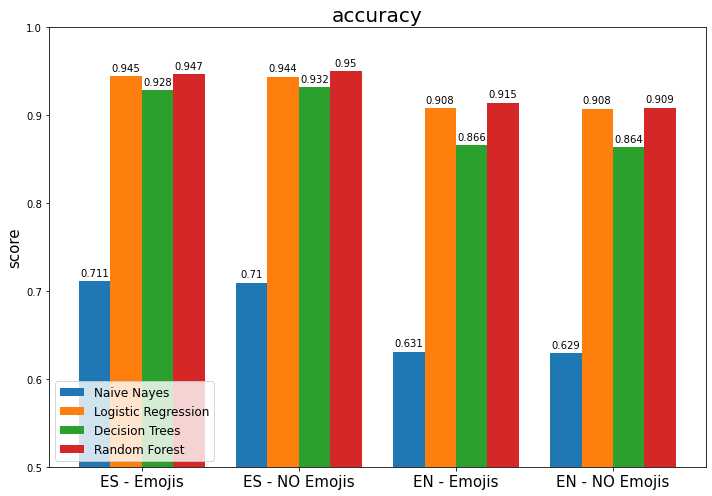

In [45]:
plot_metric('accuracy')

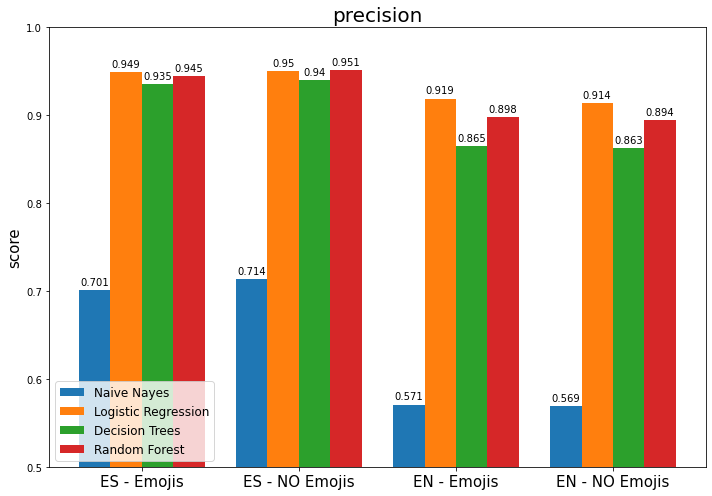

In [47]:
plot_metric('precision')

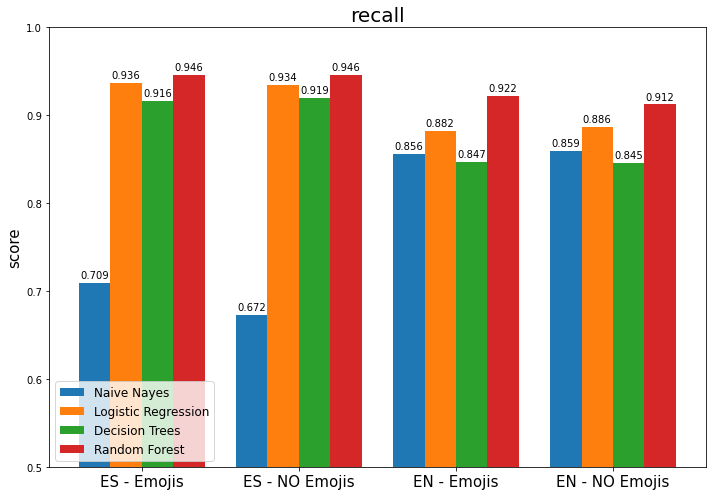

In [48]:
plot_metric('recall')

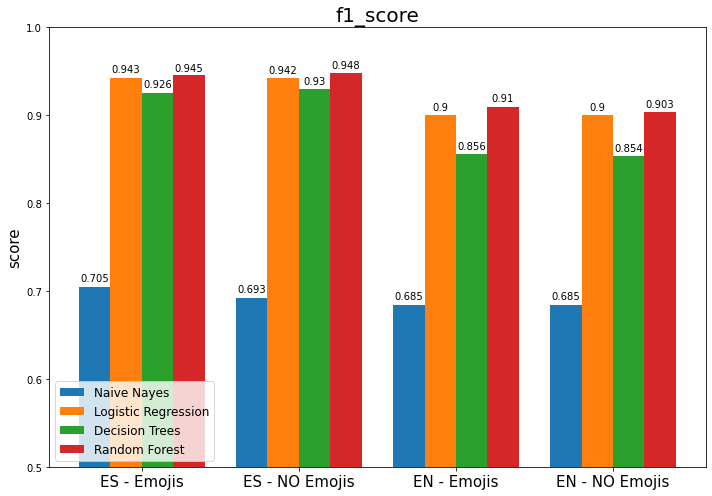

In [49]:
plot_metric('f1_score')

## Feature Importance

In [50]:
LR_Clf.coef_

array([[-0.20602517,  1.11316003, -0.23495543, ..., -0.14232185,
        -0.02086603, -0.14541133]])